# Deep unsupervised learning HW 2

In [0]:
import numpy as np
def sample_data():
  count = 6000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
X, y  = sample_data()

In [0]:
import matplotlib.pyplot as plt

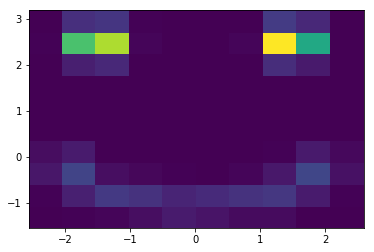

In [0]:
plt.hist2d(X[:,0],X[:,1])
plt.show()

Different paramters

In [0]:
import torch 
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F

In [0]:
class flow(nn.Module):
    
    def __init__(self,k=6):
        
        super(flow,self).__init__()
        self.k=k
        
        #layers
        self.layers= nn.Sequential(nn.Linear(1,100),
                                  nn.Tanh()
                                  )
        
        self.network = nn.Sequential(*self.layers)
        self.pi = nn.Linear(100,self.k)
        self.mu = nn.Linear(100,self.k)
        self.sigma = nn.Linear(100,self.k)

        
    def forward(self,x):
        x = self.network(x)
        pi = F.softmax(self.pi(x),dim=-1).view(-1,self.k)
        mu = self.mu(x).view(-1,self.k)
        sigma = torch.exp(self.sigma(x).view(-1,self.k))
        
        return pi, mu, sigma

        
class mycdf(nn.Module):
  
    def __init__(self, k=6):
    
      super(mycdf, self).__init__()
      self.k = k
      self.batch = 0
      self.pi = nn.Parameter(torch.randn(self.k,requires_grad=True))
      self.mu = nn.Parameter(torch.randn(self.k,requires_grad=True))
      self.sigma = nn.Parameter(torch.randn(self.k,requires_grad=True))
      
      self.fx2x1 = flow(self.k)
      
    def x_split(self,x):
      x1,x2 = x[:,0],x[:,1]
      self.batch=x1.shape[0]
      
      x1 = x1.reshape(-1,1)
      x2 = x2.reshape(-1,1)
      return x1,x2
    
    def pi_mu_sigma(self,x):
      x1, x2 = self.x_split(x)
      

      pi1, mu1, sigma1 = F.softmax(self.pi.repeat(self.batch,1)),self.mu.repeat(self.batch,1),torch.exp(self.sigma.repeat(self.batch,1))
      pi2, mu2, sigma2 = self.fx2x1.forward(x1)
      
      return (pi1, mu1, sigma1, pi2, mu2, sigma2 )
    
    def f(self,x):
      
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.pi_mu_sigma(x)
      
      z1 = torch.zeros(self.batch,1)
      z2 = torch.zeros(self.batch,1)
      
      x1, x2 = self.x_split(x)
      
      for i in range(self.k):
        z1 += pi1[:,i:i+1]*(Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).cdf(x1))
        z2 += pi2[:,i:i+1]*(Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).cdf(x2))
      return z1,z2
    
    def probs(self,x):
      
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.pi_mu_sigma(x)      
      
      prob_x1 = torch.zeros(self.batch,1)
      prob_x2 = torch.zeros(self.batch,1)
      
      x1, x2 = self.x_split(x)
      
      for i in range(self.k):
        prob_x1 += pi1[:,i:i+1]*(Normal(mu1[:,i:i+1].float(),(sigma1[:,i:i+1]).float()).log_prob(x1).exp())
        prob_x2 += pi2[:,i:i+1]*(Normal(mu2[:,i:i+1].float(),(sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
      return prob_x1*prob_x2
    
    def loss(self,x):
      return torch.mean(-torch.log(self.probs(x))/np.log(2))/2


In [0]:
mycdf = mycdf(12)

In [0]:
mycdf.loss(torch.Tensor(X[0:2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(3.8260, grad_fn=<DivBackward0>)

In [0]:
print(mycdf)
optimizer = torch.optim.Adam(mycdf.parameters(),lr=1e-3)
for param in mycdf.parameters():
    print(type(param.data), param.size())

mycdf(
  (fx2x1): flow(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (network): Sequential(
      (0): Linear(in_features=1, out_features=100, bias=True)
      (1): Tanh()
    )
    (pi): Linear(in_features=100, out_features=12, bias=True)
    (mu): Linear(in_features=100, out_features=12, bias=True)
    (sigma): Linear(in_features=100, out_features=12, bias=True)
  )
)
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([12, 100])
<class 'torch.Tensor'> torch.Size([12])


In [0]:
class DataSet:

    def __init__(self,X,y):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        
        self.images = X
        self.labels = y

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """

        img = self.images[idx]
        label = self.labels[idx]

        return img, label

In [0]:
ds = DataSet(torch.FloatTensor(X[:5000]),torch.FloatTensor(y[:5000]))
ds2 = DataSet(torch.FloatTensor(X[5000:5500]),torch.FloatTensor(y[5000:5500]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 3.4999961853027344 val_loss 3.4636776447296143 
Epoch 50: loss 2.277039051055908 val_loss 2.22599196434021 
Epoch 100: loss 1.7340192794799805 val_loss 1.7133979797363281 
Epoch 150: loss 1.6432878971099854 val_loss 1.6267735958099365 
Epoch 200: loss 1.56332528591156 val_loss 1.5461347103118896 
Epoch 250: loss 1.4881178140640259 val_loss 1.4692414999008179 
Epoch 300: loss 1.4198968410491943 val_loss 1.3993918895721436 
Epoch 350: loss 1.3602111339569092 val_loss 1.3381768465042114 
Epoch 400: loss 1.308778166770935 val_loss 1.2851011753082275 
Epoch 450: loss 1.2642567157745361 val_loss 1.2386901378631592 
Epoch 500: loss 1.225191354751587 val_loss 1.197522759437561 
Epoch 550: loss 1.1904340982437134 val_loss 1.1605931520462036 
Epoch 600: loss 1.159189224243164 val_loss 1.1273009777069092 
Epoch 650: loss 1.1309349536895752 val_loss 1.0969830751419067 
Epoch 700: loss 1.1053669452667236 val_loss 1.0694981813430786 
Epoch 750: loss 1.082324504852295 val_loss 1.0445898

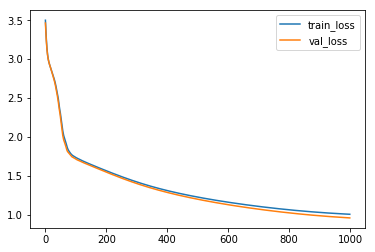

In [0]:
epochs=1000

losses, val_losses =[],[]
batch_size=50


train_iter = torch.utils.data.DataLoader(dataset=ds,batch_size=len(ds),shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=ds2,batch_size=len(ds2),shuffle=True)

losses = []
val_losses = []

for epoch in range(epochs):

    loss = 0
    tmp_losses = []
    
    for train_X, train_y in train_iter:

        loss = mycdf.loss(train_X)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        tmp_losses.append(loss.data.numpy())

        del loss
        loss = 0

        

    with torch.set_grad_enabled(False):
        tmp_val_losses = []
        for val_X, val_y in val_iter:
            val_loss = mycdf.loss(val_X)
            val_losses.append(val_loss.data.numpy())
            tmp_val_losses.append(val_loss.data.numpy())

    if epoch % 50 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [0]:
from torch.autograd import Variable

def sample_preds(pi, sigmasq, mu, samples=1000):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out


In [0]:
pi1, mu1, sigma1 = F.softmax(mycdf.pi).view(1,-1),mycdf.mu.view(1,-1),torch.exp(mycdf.sigma).view(1,-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [0]:
preds_x = sample_preds(pi1, sigma1, mu1, samples=10000)

In [0]:
pi2, mu2, sigma2 = mycdf.fx2x1(preds_x)

In [0]:
pi1.shape

torch.Size([1, 12])

In [0]:
predsx2 = sample_preds(pi2,sigma2,mu2,samples=1)

In [0]:
preds_x.shape

torch.Size([1, 10000, 1])

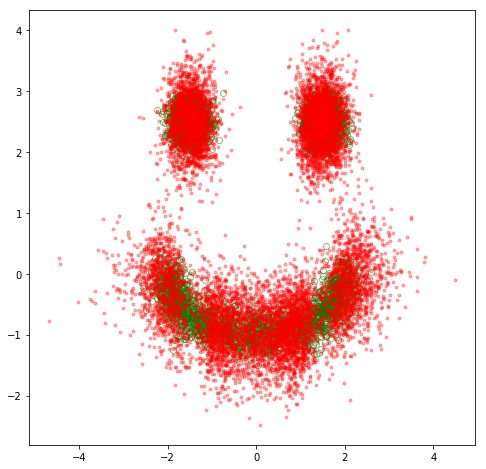

In [0]:
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'go', alpha=0.5, markerfacecolor='none')
for i in range(predsx2.shape[0]):
  plt.plot(preds_x.squeeze(0).detach().numpy()[i], predsx2.squeeze(1).numpy()[i], 'r.', alpha=0.3)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


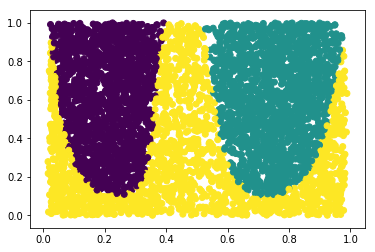

In [0]:
fig = plt.figure()
z1,z2 = mycdf.f(train_X)
plt.scatter(z1.data.numpy(),z2.data.numpy(), c = np.reshape(train_y,[5000,1]))



In [0]:
train_X.shape

torch.Size([5000, 2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


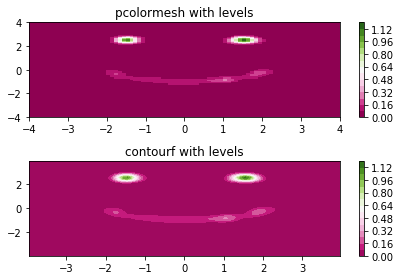

In [0]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
dx, dy = 0.1, 0.1

# generate 2 2d grids for the x & y bounds
_y, _x = np.mgrid[slice(-4, 4 + dy, dy),
                slice(-4, 4 + dx, dx)]

constructed_input = np.array([_x.reshape(-1),_y.reshape(-1)]).T

z = mycdf.probs(torch.Tensor(constructed_input)).data.numpy()
z = z.reshape(int(np.sqrt(z.shape[0])),-1)

#z = np.sin(_x)**10 + np.cos(10 + _y*_x) * np.cos(_x)
#print(z.shape)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(_x, _y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(_x[:-1, :-1] + dx/2.,
                  _y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

## RealNVP

In [0]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [0]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [0]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] *3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

Epoch 0: loss 6.534258842468262 val_loss 6.077445030212402 
Epoch 10: loss 5.379456520080566 val_loss 5.3538641929626465 
Epoch 20: loss 5.1409430503845215 val_loss 5.094646453857422 
Epoch 30: loss 4.813189506530762 val_loss 4.726604461669922 
Epoch 40: loss 4.201460838317871 val_loss 4.092822551727295 
Epoch 50: loss 3.6197495460510254 val_loss 3.4737446308135986 
Epoch 60: loss 3.153576612472534 val_loss 3.029421329498291 
Epoch 70: loss 2.8470215797424316 val_loss 2.7384109497070312 
Epoch 80: loss 2.641875743865967 val_loss 2.544644594192505 
Epoch 90: loss 2.511457920074463 val_loss 2.4166269302368164 
Epoch 100: loss 2.4146885871887207 val_loss 2.3059544563293457 
Epoch 110: loss 2.3483357429504395 val_loss 2.240755319595337 
Epoch 120: loss 2.300555467605591 val_loss 2.2001328468322754 
Epoch 130: loss 2.2644567489624023 val_loss 2.168184757232666 
Epoch 140: loss 2.237034559249878 val_loss 2.139197826385498 
Epoch 150: loss 2.2157254219055176 val_loss 2.125969171524048 
Epoch 

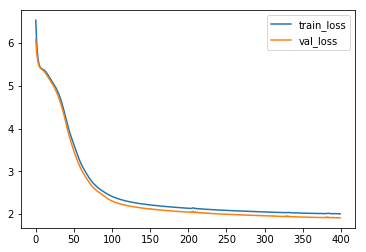

In [0]:
epochs=400
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4, weight_decay=1e-8)
batch_size=50


train_iter = torch.utils.data.DataLoader(dataset=ds,batch_size=len(ds),shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=ds2,batch_size=len(ds2),shuffle=True)

losses = []
val_losses = []

for epoch in range(epochs):

    loss = 0
    for train_X, train_y in train_iter:
      
        loss = -(flow.log_prob(train_X)/torch.tensor(np.log(2))).mean()

        loss.backward(retain_graph=True)    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())

        del loss
        loss = 0

        

    with torch.set_grad_enabled(False):
        for val_X, val_y in val_iter:
            val_loss = -(flow.log_prob(val_X)/torch.tensor(np.log(2))).mean()
            val_losses.append(val_loss.data.numpy())

    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

#for t in range(5001):    
    #noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
#    loss = -flow.log_prob(torch.from_numpy(data.astype(np.float32))).mean()
    
#    optimizer.zero_grad()
#    loss.backward(retain_graph=True)
#    optimizer.step()
    
#    if t % 500 == 0:
#        print('iter %s:' % t, 'loss = %.3f' % loss)

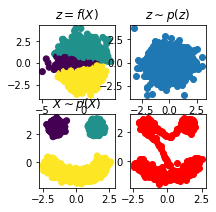

In [0]:
fig = plt.figure(figsize=(3, 3))
z = flow.f(train_X)[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], c=train_y)
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')


plt.subplot(223)
x = train_X #datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c=train_y)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')


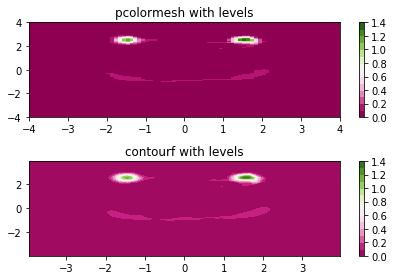

In [0]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
dx, dy = 0.1, 0.1

# generate 2 2d grids for the x & y bounds
_y, _x = np.mgrid[slice(-4, 4 + dy, dy),
                slice(-4, 4 + dx, dx)]

constructed_input = np.array([_x.reshape(-1),_y.reshape(-1)]).T

z = flow.log_prob(torch.Tensor(constructed_input)).exp().data.numpy()
z = z.reshape(int(np.sqrt(z.shape[0])),-1)

#z = np.sin(_x)**10 + np.cos(10 + _y*_x) * np.cos(_x)
#print(z.shape)

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(_x, _y, z, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(_x[:-1, :-1] + dx/2.,
                  _y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

 # CELEB A

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [0]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [0]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [0]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image
""" data """
crop_size = 108
re_size = 32
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]
quan = lambda x: torch.FloatTensor(np.digitize(x,bins=[0,0.25,0.5,0.75]))/4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Lambda(quan),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 32
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
data_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)


  ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


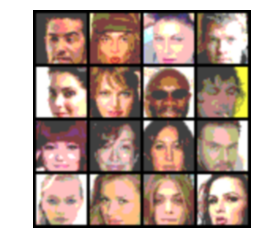

In [0]:
batch, _ = next(iter(data_loader))
show(batch[0:16], renorm = True, nrow=4)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision
import torch.distributions as distributions
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetBlock(nn.Module):
    def __init__(self,channels=128):

        super(ResNetBlock,self).__init__()
        self.channels=channels

        self.network = nn.Sequential(nn.ReLU(),
        nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0),nn.BatchNorm2d(self.channels), nn.ReLU(),
        nn.Conv2d(self.channels,self.channels, 3, stride=1, padding=1),nn.BatchNorm2d(self.channels), nn.ReLU(),
        nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),nn.BatchNorm2d(2*self.channels)
        )

    def forward(self,x):
        out= self.network(x)
        return x+out
        

In [0]:
class AbstractCoupling(nn.Module):
    def __init__(self, mask_config, channels, num_layers=1):
        """Initializes an AbstractCoupling.
        Args:
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(AbstractCoupling, self).__init__()
        self.mask_config = mask_config
        self.prior = distributions.Normal(   # isotropic standard normal distribution
        torch.tensor(0.).to(device), torch.tensor(1.).to(device))

        self.layers=[nn.Conv2d(3,channels*2, 7, stride=1, padding=3)]
        for m in range(0, num_layers):
            self.layers.append(ResNetBlock(channels))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(2*channels, 6, 1, 1, 0))
        
        self.network = nn.Sequential(*self.layers)
        
    def build_mask(self, size, config=1.):
        """Builds a binary checkerboard mask.
        (Only for constructing masks for checkerboard coupling layers.)
        Args:
            size: height/width of features.
            config: mask configuration that determines which pixels to mask up.
                    if 1:        if 0:
                        1 0         0 1
                        0 1         1 0
        Returns:
            a binary mask (1: pixel on, 0: pixel off).
        """
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(config + mask, 2)
        mask = mask.reshape(-1, 1, size, size)
        return torch.tensor(mask.astype('float32'))
    
    def forward(self,x, reverse=False):
        x1 = x
        x_mask = self.build_mask(x.shape[2],x.shape[3]).to(device)
        _x = x*x_mask
        

        x = self.network(_x)
        log_s, t = torch.chunk(x, 2, dim=1)
        log_s *= 1-x_mask
        t *= 1-x_mask
        
        #if not reverse:
        #    x = torch.exp(log_s)*(x1 + t)
        #else:
        #    x = torch.exp(-log_s)*x1 - t
         
        if reverse:       
            x = _x + (1 - x_mask) * ((x1 - t) * torch.exp(-log_s))
        else:
            x = _x + (1-x_mask)* (x1 * torch.exp(log_s) + t)
                        
        log_det = log_s.view(x1.shape[0],-1).sum(dim=1)
             
        return (x, log_det)
    
    def log_prob(self, x):
        """Computes data log-likelihood.
        (See Eq(2) and Eq(3) in the real NVP paper.)
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        z, log_det_J = self.forward(x, False)
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J
    
    def sample(self, size):
        """Generates samples.
        Args:
            size: number of samples to generate.
        Returns:
            samples from the data space X.
        """

        z = self.prior.sample((size, 3, re_size, re_size))
        return self.forward(z, True)
    

In [0]:
net = AbstractCoupling(1, 8).cuda()

In [0]:
batch[0:1].shape

torch.Size([1, 3, 32, 32])

In [0]:
x1,x2 = net.forward(batch[0:3].cuda())

In [0]:
z, _ = net.sample(3)

In [0]:
z.shape

torch.Size([3, 3, 32, 32])

In [0]:
net.log_prob(batch[0:3])


tensor([-3377.5867, -3205.1633, -3464.4761], grad_fn=<AddBackward0>)

In [0]:
n = len(data_loader)

In [0]:
print(net)
optimizer = torch.optim.Adam(net.parameters(),lr=3e-4, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

AbstractCoupling(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ResNetBlock(
      (network): Sequential(
        (0): ReLU()
        (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ReLU()
    (3): Conv2d(16, 6, kernel_size=(1, 1), stride=(1, 1))
  )
)
<class 'torch.Tensor'> torch.Size([16, 3, 7, 7])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([8, 16, 1, 1])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0: loss [0.09087705] val_loss [0.7531157] 
data space


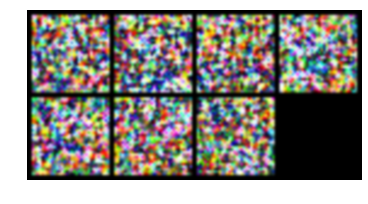

latent space


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


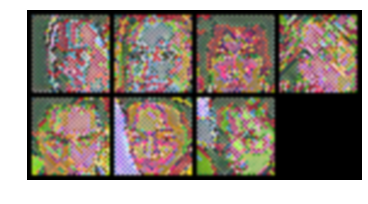

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1: loss [0.06975143] val_loss [0.10793916] 
data space


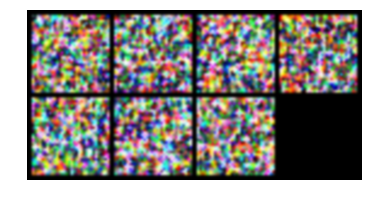

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


latent space


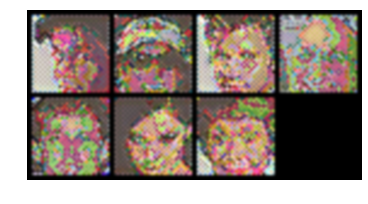

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2: loss [0.09984259] val_loss [0.12034649] 
data space


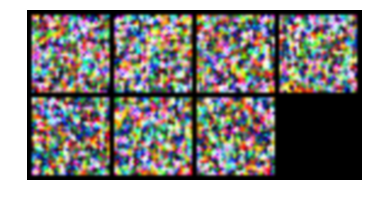

latent space


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


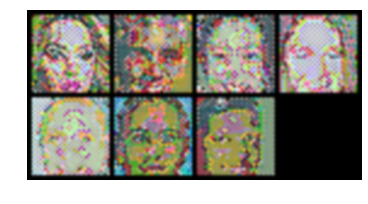

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3: loss [0.03178889] val_loss [0.08192159] 
data space


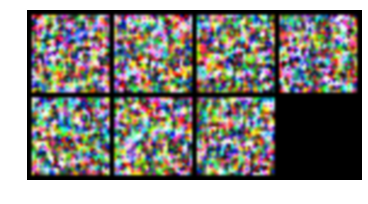

latent space


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


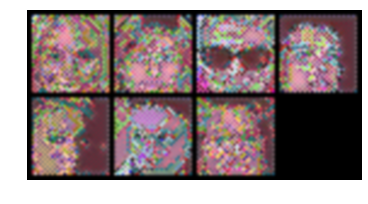

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4: loss [0.13250609] val_loss [0.11525834] 
data space


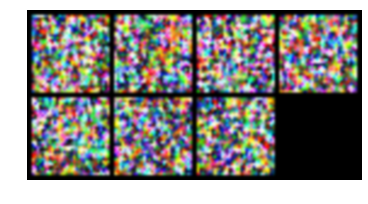

latent space


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


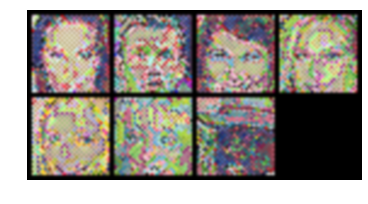

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5: loss [0.03853245] val_loss [0.08384651] 
data space


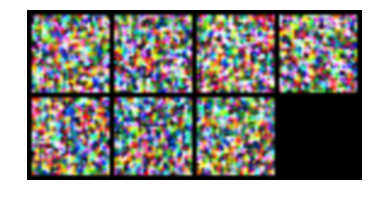

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


latent space


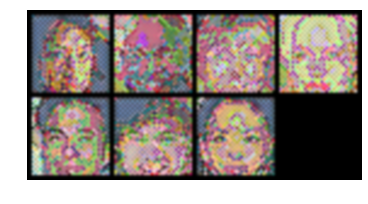

KeyboardInterrupt: ignored

In [0]:

dim_factor = torch.FloatTensor([3*32*32]).to(device)
log_factor = torch.log(torch.Tensor([2])).to(device)

loss_epoch, val_loss_epoch = [],[]

for epoch in range(20):
    losses, val_losses =[],[]
    count =0
    for train_batch in data_loader:
        count +=1

        if count < 1000:
            with torch.set_grad_enabled(False):
                net.eval()
                train_batch = train_batch[0].to(device)
                loss = -torch.mean(net.log_prob(train_batch))/dim_factor*log_factor
                val_losses.append(loss.data.cpu().numpy())

        else:
            net.train()
            train_batch = train_batch[0].to(device)
            loss = -torch.mean(net.log_prob(train_batch))/dim_factor*log_factor
            losses.append(loss.data.cpu().numpy())

            loss.backward()    
            optimizer.step()
            optimizer.zero_grad()

        if count % (n) == 0:
            print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))
            break
            
                # -- Plotting --
    if epoch % 1 == 0:
        with torch.no_grad():
            z, _ = net.sample(train_batch.shape[0])
            z_hat, _ = net.forward(train_batch)
            x_hat, _ = net.forward(z,True)



        # Data space
        print('data space')
        show(x_hat.cpu(), renorm = True, nrow=4)

        # Latent space
        print('latent space')
        show(z_hat.cpu(), renorm = True, nrow=4)

    loss_epoch.append(np.mean(losses))
    val_loss_epoch.append(np.mean(val_losses))
            


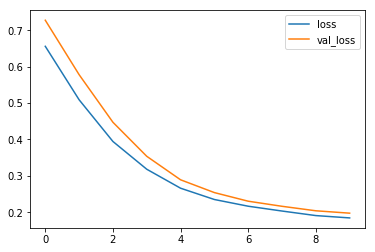

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, len(loss_epoch)), loss_epoch, label = "loss")
plt.plot(np.arange(0, len(val_loss_epoch)), val_loss_epoch, label = "val_loss")
plt.legend()
plt.show()